In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.cnf.odometry import CNFOdometry
from nf_slam.cnf.mapping import CNFMapBuilder, CNFMapBuildingConfig, RectangleBoundary, CNFMapModelConfig
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.plotting_utils import show_points
from nf_slam.utils.universal_factory import UniversalFactory
from nf_slam.space_hashing_mapping.mlp_model import MLPModel, NormMLPModel
from nf_slam.space_hashing_mapping.mapping import MapBuilder, LearningConfig, OptimizerConfig, ScanData
from nf_slam.plotting_utils import plot_positions, plot_model_heatmap_cnf, get_points,\
    show_points_in_reconstructed_positions, get_points_in_reconstructed_positions
import tqdm
import matplotlib.pyplot as plt
from clearml import Task
import numpy as np
import jax.numpy as jnp

ROS is not sourced. To enable ROS features, please source it


# Init ClearMl task

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
datafile = "/home/mikhail/Downloads/intel.log"
laser_data_list = dataset_loader.load(datafile)

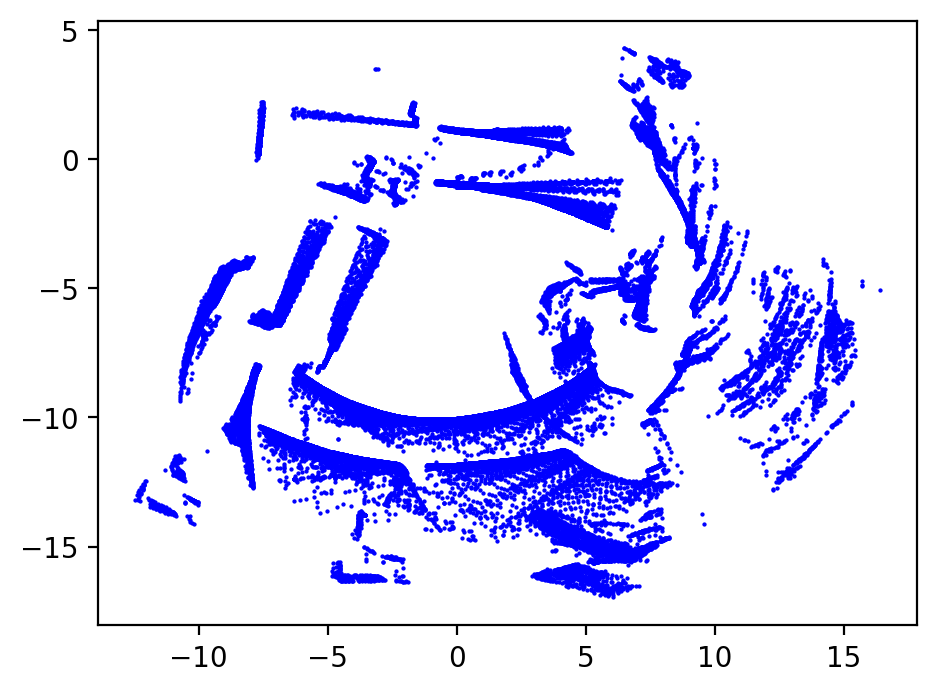

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[0:1000:2], c="blue");

# NF Odometry

In [5]:
task = Task.init(project_name='nf_2d_odometry', task_name='classification_map_odometry')
logger = task.get_logger()
iteration = 0

ClearML Task: created new task id=ea5cc36f16d74698b4b8b492b05fdf0e
======> WARNING! Git diff to large to store (678kb), skipping uncommitted changes <======
ClearML results page: https://app.community.clear.ml/projects/5e249aee257e4b25a774e1d12bff4ad3/experiments/ea5cc36f16d74698b4b8b492b05fdf0e/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [20]:
parameters = {
    'mlp_model': {
        "type": "NormMLPModel",
    },
    'map_model_config': {
        'type': "CNFMapModelConfig",
        'minimal_depth': 0.05,
        'maximal_depth': 10,
        'F': 4,
        'L': 16,
        'T': 4096,
        'min_log_resolution': -3,
        'max_log_resolution': 3.5,
    },
    'learning_config': {
        "type": "LearningConfig",
        'iterations': 100,
        'variable_optimizer_config': {
            'learning_rate': 1e-2,
            'beta1': 0.9,
            'beta2': 0.99,
            'eps': 1e-15,
            'weight_decay': 1e-5
        },
        'hashtable_optimizer_config': {
            'learning_rate': 4e-2,
            'beta1': 0.9,
            'beta2': 0.99,
            'eps': 1e-15,
            'weight_decay': 0
        }
    },
    'map_building_config': {
        "type": "CNFMapBuildingConfig",
        'sampling_depth_delta': 2.,
        'sampling_depth_count': 40,
        'point_loss_weight': 1.,
        'classification_loss_weight': 150.,
        'random_point_loss_weight': 0,
        'random_point_count': 100,
        "random_point_boundary": RectangleBoundary(*np.array([-10, 10, -2, 2]))
    },
    'cnf_odometry': {
        "type": "CNFOdometry",
        "parameters": {
            'tracking_iterations': 7,
            'mapping_iterations': 0,
            'batch_mapping_iterations': 4,
            'mapping_batch_count': 5,
            'point_count': 100
        },
        "batch_map_builder": {},
        "position_optimizer": {
            "config": {
                'learning_rate': 1,
                'iterations': 100,
                'init_hessian': jnp.diag(jnp.array([200, 200, 200])),
                'maximal_clip_norm': 100,
                'beta1': 0.5,
                'beta2': 0.3,
                'hessian_adder': jnp.diag(jnp.array([200, 200, 200])) * 0.1,
                'tracking_config': {'huber_scale': 2}
            }
        },
        "map_builder": {}
    },
    "maximal_laser_data_id": 13631,
    "minimal_laser_data_id": 0,
    "skip_laser_data": 2,
    }
iteration += 1
task.connect(parameters);

2022-09-12 20:04:46,137 - clearml.Task - WARNING - Skipping parameter: General/map_building_config/random_point_boundary[RectangleBoundary], General/cnf_odometry/position_optimizer/config/init_hessian[DeviceArray], General/cnf_odometry/position_optimizer/config/hessian_adder[DeviceArray], only builtin types are supported (tuple, str, int, list, NoneType, dict, float)


In [21]:
universal_factory = UniversalFactory([CNFOdometry, MLPModel, CNFMapModelConfig, LearningConfig, 
                                      CNFMapBuildingConfig, NormMLPModel])
order = ["mlp_model", "map_model_config", "map_model_config", "learning_config", "map_building_config",
    "cnf_odometry"]
odometry = universal_factory.iterative_make(order, parameters)

In [22]:
processed_data_list = laser_data_list[
    parameters["minimal_laser_data_id"]:parameters["maximal_laser_data_id"]:parameters["skip_laser_data"]]

In [23]:
odometry.setup()
reconstructed_odometry_positions = []
for laser_data in tqdm.tqdm(processed_data_list):
    odometry.step(laser_data)
    reconstructed_odometry_positions.append(odometry.current_position)

 14%|████████████████████████████████▏                                                                                                                                                                                                         | 936/6816 [04:49<30:17,  3.24it/s]


KeyboardInterrupt: 

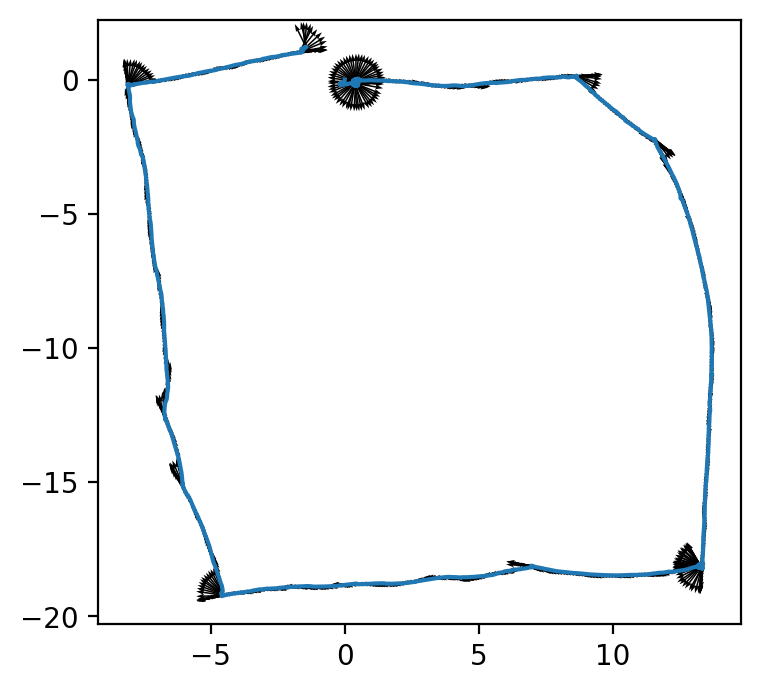

In [24]:
indexes = (0, 4000)
fig=plt.figure(dpi=200)
plot_positions(reconstructed_odometry_positions)
plt.gca().set_aspect("equal")
logger.report_matplotlib_figure("reconstructed_trajectory", "intel lab", fig, iteration, report_image=True)

In [25]:
len(laser_data_list)

13631

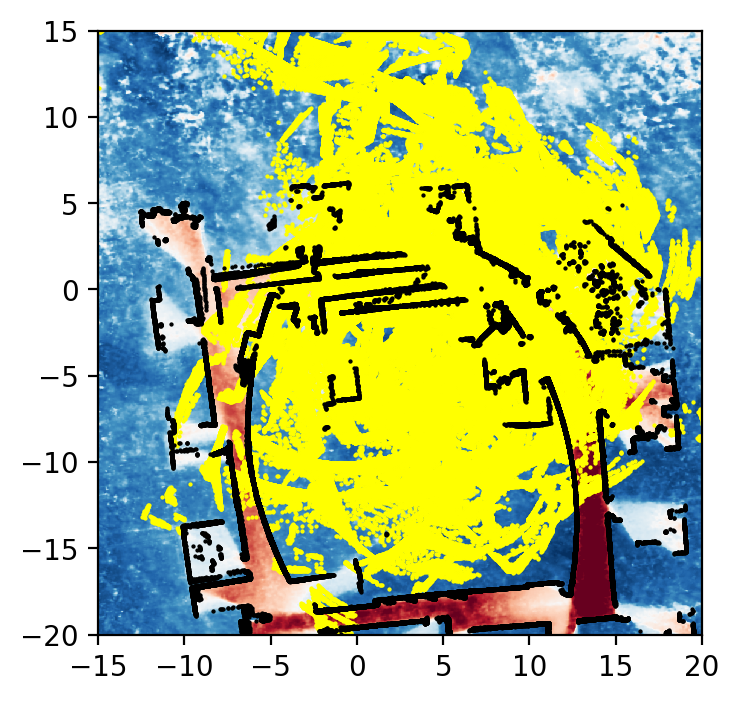

In [30]:
fig=plt.figure(dpi=200)
map_model = odometry.map_model
# points = get_points_in_reconstructed_positions(processed_data_list, reconstructed_odometry_positions)
points = get_points(processed_data_list)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, 
          np.max(points[:, 1]) + 1)
bounds = (-15, 20, -20, 15)
plot_model_heatmap_cnf(map_model, bounds, odometry._mlp_model, grid_shape=(1000, 1000), vmin=-10, vmax=10)
show_points(processed_data_list);
plt.xlim(bounds[0], bounds[1])
plt.ylim(bounds[2], bounds[3])
show_points_in_reconstructed_positions(processed_data_list, reconstructed_odometry_positions, c="black");
logger.report_matplotlib_figure("neural field", "intel lab", fig, iteration, report_image=True);

In [15]:
jnp.std(map_model.hashtable, axis=1)

DeviceArray([[ 4.2803016,  4.9340415,  5.7106485,  4.508154 ],
             [ 5.63982  ,  6.0067663,  5.215426 ,  5.3040214],
             [ 9.119868 ,  8.368576 ,  5.365317 ,  5.544429 ],
             [ 7.607783 ,  6.930212 ,  6.652016 , 10.043185 ],
             [ 6.57199  ,  6.370376 ,  4.7023892,  6.9346848],
             [ 4.307858 ,  8.862846 ,  7.7954664,  7.323686 ],
             [ 3.5048282,  4.2395835,  6.379033 ,  4.2170067],
             [ 2.4310184,  2.6486683,  3.8132887,  2.42639  ],
             [ 2.0570772,  1.7685833,  1.56488  ,  2.661303 ],
             [ 1.4299849,  1.4624631,  1.8019582,  1.5153341],
             [ 1.2479166,  1.4982041,  1.5742924,  1.620024 ],
             [ 1.1890162,  1.3287785,  1.2858248,  1.2940139],
             [ 1.2486012,  1.2002587,  1.23454  ,  1.4065148],
             [ 1.6984129,  1.2285903,  1.3709679,  1.105162 ],
             [ 1.1744826,  1.0897882,  1.165992 ,  1.2264684],
             [ 1.0325875,  1.1632069,  1.1471415,  1.09

In [88]:
task.close()